In [ ]:
!nvidia-smi

Sun Feb 18 07:14:16 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   77C    P0              34W /  70W |   4961MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

#Resume Classification using BERT

##Import Libraries


In [ ]:
!pip install cohere -q
!pip install --upgrade cohere -q

In [ ]:

import cohere
import pandas as pd
import random
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from sklearn.metrics import classification_report
from sklearn.metrics import matthews_corrcoef
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import gensim.downloader
from sklearn.metrics.pairwise import cosine_similarity
import nltk
import re
import matplotlib.pyplot as plt
from transformers import BertTokenizer, BertForSequenceClassification
import torch

import numpy as np

try:
    import torch
except:
    !pip -qq install torch

import torch.nn as nn

try:
    import transformers
except:
    !pip -qq install transformers

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('words')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

##Review Dataset

In [ ]:
resumeDataSet = pd.read_csv('/content/drive/MyDrive/UpdatedResumeDataSet_T2_18.csv' ,encoding='utf-8')
resumeDataSet.head()

Category                                             Resume
0  Data Science  qwtnrvduof Skills * Programming Languages: Pyt...
1  Data Science  qwtnrvduof Education Details \nMay 2013 to May...
2  Data Science  qwtnrvduof Areas of Interest Deep Learning, Co...
3  Data Science  Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...
4  Data Science  SKILLS C Basics, IOT, Python, MATLAB, Data Sci...

In [ ]:
null_values = resumeDataSet.isnull().sum()                  # Check for null values
print("Null values:")
print(null_values)

duplicate_rows = resumeDataSet[resumeDataSet.duplicated()]  # Check for duplicates
print("Duplicate:",len(duplicate_rows))

Null values:
Category    0
Resume      0
dtype: int64
Duplicate: 9401


In [ ]:
resumeDataSet.drop_duplicates(subset=['Category', 'Resume'], inplace=True)  #Delete Duplicates

In [ ]:
print ("Displaying the distinct categories of resume and the number of records belonging to each category -")
print (resumeDataSet['Category'].value_counts())

Displaying the distinct categories of resume and the number of records belonging to each category -
Java Developer               14
Data Science                 13
HR                           13
Database                     12
Advocate                     11
DotNet Developer              8
Hadoop                        8
DevOps Engineer               8
Testing                       8
Civil Engineer                7
Business Analyst              7
SAP Developer                 7
Health and fitness            7
Python Developer              7
Arts                          7
Automation Testing            7
Electrical Engineering        6
Sales                         6
Network Security Engineer     6
Mechanical Engineer           6
ETL Developer                 6
Blockchain                    6
Operations Manager            5
Web Designing                 5
PMO                           4
Name: Category, dtype: int64


<Axes: xlabel='count', ylabel='Category'>

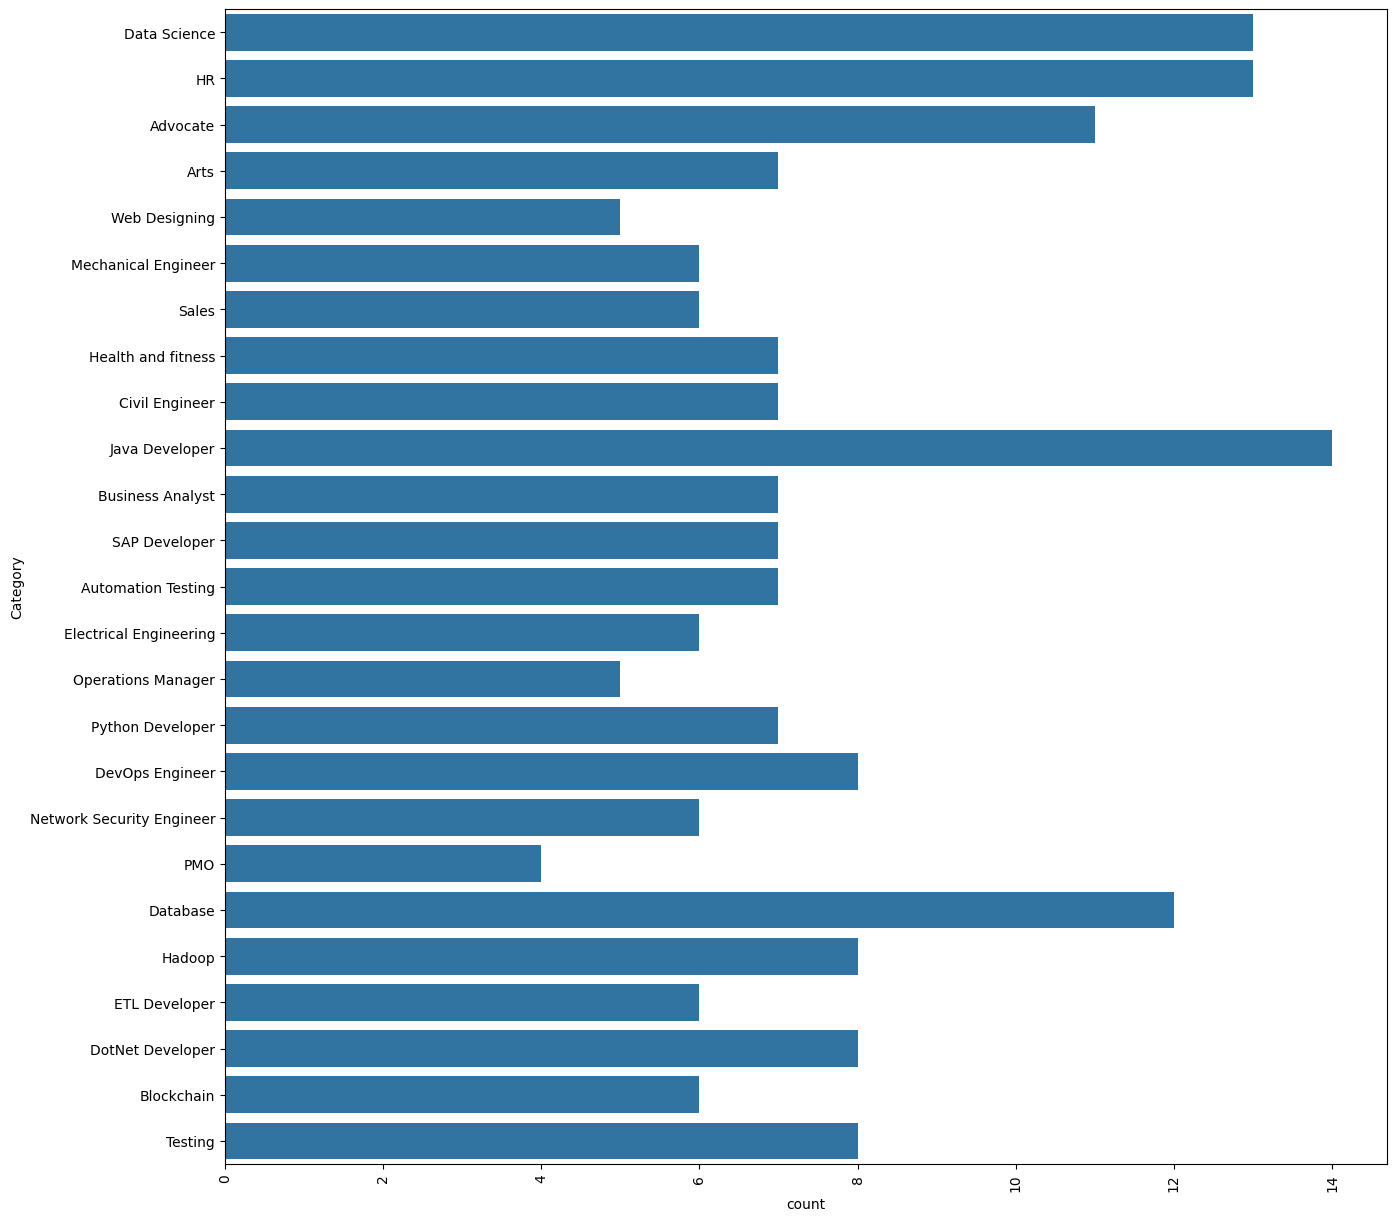

In [ ]:
import seaborn as sns
plt.figure(figsize=(15,15))
plt.xticks(rotation=90)
sns.countplot(y="Category", data=resumeDataSet)

##Pre-Processing

In [ ]:
def preprocess_text(resumeText):
    #From Kaggle Preprocessing
    resumeText = re.sub('http\S+\s*', ' ', resumeText)  # remove URLs
    resumeText = re.sub('RT|cc', ' ', resumeText)  # remove RT and cc
    resumeText = re.sub('#\S+', '', resumeText)  # remove hashtags
    resumeText = re.sub('@\S+', '  ', resumeText)  # remove mentions
    resumeText = re.sub('[%s]' % re.escape("""!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"""), ' ', resumeText)  # remove punctuations
    resumeText = re.sub(r'[^\x00-\x7f]',r' ', resumeText)
    resumeText = re.sub('\s+', ' ', resumeText)  # remove extra whitespace
    resumeText = re.sub(r'[^\x00-\x7f]', ' ', resumeText)  # Remove non-ASCII characters
    resumeText = re.sub('\d+', ' ', resumeText)
    resumeText = resumeText.lower()

    #My Preprocessing
    stop_words = set(stopwords.words('english'))
    tokens = word_tokenize(resumeText)
    tokens = [word for word in tokens if word.lower() not in stop_words]

    resumeText = ' '.join(tokens)
    resumeText = ' '.join(word for word in resumeText.split() if len(word) > 1)  # Remove short words
    return resumeText

In [ ]:
resumeDataSet['Cleaned_Resume'] = resumeDataSet['Resume'].apply(preprocess_text)

In [ ]:
resumeDataSet.head(5)

Category                                             Resume  \
0  Data Science  qwtnrvduof Skills * Programming Languages: Pyt...   
1  Data Science  qwtnrvduof Education Details \nMay 2013 to May...   
2  Data Science  qwtnrvduof Areas of Interest Deep Learning, Co...   
3  Data Science  Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...   
4  Data Science  SKILLS C Basics, IOT, Python, MATLAB, Data Sci...   

                                      Cleaned_Resume  
0  qwtnrvduof skills programming languages python...  
1  qwtnrvduof education details may may bbntgbqlm...  
2  qwtnrvduof areas interest deep learning contro...  
3  skills python sap hana tableau sap hana sql sa...  
4  skills basics iot python matlab data science m...

In [ ]:
#Increase Data size by changing random words with its synonyms
def getsynonyms(word):
    synonyms = []
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            synonyms.append(lemma.name())
    return synonyms

def randomize_sentence(sentence, num_replacements=1):
    words = sentence.split()
    for i in range(num_replacements):
        word_to_replace = random.choice(words)
        synonyms = getsynonyms(word_to_replace)
        if synonyms:
            synonym = random.choice(synonyms)
            sentence = sentence.replace(word_to_replace, synonym, 1)
    return sentence

for i in range(len(resumeDataSet)):

  input_sentence = resumeDataSet['Cleaned_Resume'][i]
  num_replacements = 20

  randomized_sentence = randomize_sentence(input_sentence, num_replacements)
  new_row = {'Cleaned_Resume': randomized_sentence, 'Category': resumeDataSet['Category'][i]}

  resumeDataSet = resumeDataSet.append(new_row, ignore_index=True)


<ipython-input-11-c81091e01577>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resumeDataSet = resumeDataSet.append(new_row, ignore_index=True)
<ipython-input-11-c81091e01577>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resumeDataSet = resumeDataSet.append(new_row, ignore_index=True)
<ipython-input-11-c81091e01577>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resumeDataSet = resumeDataSet.append(new_row, ignore_index=True)
<ipython-input-11-c81091e01577>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resumeDataSet = resumeDataSet.append(new_row, ignore_index=True)
<ipython-input-11-c81091e01577>:27: FutureWarning: The f

In [ ]:
print("No of rows in Dataset:",len(resumeDataSet.Category))

No of rows in Dataset: 388


##Vectorization

In [ ]:
# Load pre-trained BERT model for sequence classification
model = BertForSequenceClassification.from_pretrained('bert-base-uncased')

# Load pre-trained BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
def vectorize_text(cleaned_resume):
    # Tokenize the text using BERT tokenizer
    tokenized_input = tokenizer(cleaned_resume, return_tensors='pt', truncation=True, padding=True)

    # Return the input IDs (vectorized representation)
    return tokenized_input['input_ids'].squeeze()

In [ ]:
resumeDataSet['Vectorized_Embeddings'] = resumeDataSet['Cleaned_Resume'].apply(vectorize_text)
print(resumeDataSet[['Cleaned_Resume', 'Vectorized_Embeddings']].head())

                                      Cleaned_Resume  \
0  qwtnrvduof skills programming languages python...   
1  qwtnrvduof education details may may bbntgbqlm...   
2  qwtnrvduof areas interest deep learning contro...   
3  skills python sap hana tableau sap hana sql sa...   
4  skills basics iot python matlab data science m...   

                               Vectorized_Embeddings  
0  [tensor(101), tensor(1053), tensor(26677), ten...  
1  [tensor(101), tensor(1053), tensor(26677), ten...  
2  [tensor(101), tensor(1053), tensor(26677), ten...  
3  [tensor(101), tensor(4813), tensor(18750), ten...  
4  [tensor(101), tensor(4813), tensor(24078), ten...  


##Train

In [ ]:
label_encoder = LabelEncoder()
resumeDataSet['Encoded_Category'] = label_encoder.fit_transform(resumeDataSet['Category'])

In [ ]:
resumeDataSet.head()

Category                                             Resume  \
0  Data Science  qwtnrvduof Skills * Programming Languages: Pyt...   
1  Data Science  qwtnrvduof Education Details \nMay 2013 to May...   
2  Data Science  qwtnrvduof Areas of Interest Deep Learning, Co...   
3  Data Science  Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...   
4  Data Science  SKILLS C Basics, IOT, Python, MATLAB, Data Sci...   

                                      Cleaned_Resume  \
0  qwtnrvduof skills programming languages python...   
1  qwtnrvduof education details may may bbntgbqlm...   
2  qwtnrvduof areas interest deep learning contro...   
3  skills python sap hana tableau sap hana sql sa...   
4  skills basics iot python matlab data science m...   

                               Vectorized_Embeddings  Encoded_Category  
0  [tensor(101), tensor(1053), tensor(26677), ten...                 6  
1  [tensor(101), tensor(1053), tensor(26677), ten...                 6  
2  [tensor(101), tensor(1053), tensor(26677), ten...                 6  
3  [tensor(101), tensor(4813), tensor(18750), ten...                 6  
4  [tensor(101), tensor(4813), tensor(24078), ten...                 6

In [ ]:
# Prepare sentences and labels
sentences = resumeDataSet.Cleaned_Resume.values
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
labels = resumeDataSet.Encoded_Category.values

In [ ]:
# Pad sequences and create attention masks
MAX_LEN = 128
input_ids = pad_sequences(resumeDataSet.Vectorized_Embeddings, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

attention_masks = []
for sequence in input_ids:
    sequence_mask = [float(id > 0) for id in sequence]
    attention_masks.append(sequence_mask)

In [ ]:
# Split data into training and validation sets
training_inputs, validation_inputs, training_labels, validation_labels, training_masks, validation_masks = train_test_split(
    input_ids, labels, attention_masks,
    random_state=21, test_size=0.1
)

In [ ]:
# Create DataLoader for training set
batch_size = 32
training_data = TensorDataset(torch.tensor(training_inputs), torch.tensor(training_masks), torch.tensor(training_labels))
training_sampler = RandomSampler(training_data)
training_dataloader = DataLoader(training_data, sampler=training_sampler, batch_size=batch_size)

# Create DataLoader for validation set
validation_data = TensorDataset(torch.tensor(validation_inputs), torch.tensor(validation_masks), torch.tensor(validation_labels))
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [ ]:
len(resumeDataSet.Encoded_Category.unique())

25

In [ ]:
# Configure BERT model for sequence classification
from transformers import BertConfig, BertModel
configuration = BertConfig()
model = BertModel(configuration)
configuration = model.config

from transformers import BertForSequenceClassification
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=25)
model = nn.DataParallel(model)
model.to(device)

from transformers import AdamW
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]
optimizer = AdamW(optimizer_grouped_parameters, lr=2e-5, correct_bias=False)

def flat_accuracy(predicted_labels, labels):
    predicted_labels = numpy.argmax(predicted_labels.to('cpu').numpy(), axis=1).flatten()
    labels = labels.to('cpu').numpy().flatten()
    return numpy.sum(predicted_labels == labels) / len(labels)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
# Train the BERT model
from tqdm import trange
epochs = 200
training_losses = []

for epoch in trange(epochs, desc="Epoch"):
    model.train()
    training_loss = 0
    training_steps = 0

    for step, batch in enumerate(training_dataloader):
        inputs = batch[0].to(device)
        attention_masks = batch[1].to(device)
        labels = batch[2].to(device)

        optimizer.zero_grad()
        outputs = model(inputs, attention_mask=attention_masks, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

        training_loss += loss.item()
        training_steps += 1

        training_losses.append(loss.item())

    average_training_loss = training_loss/training_steps
    print("Epoch {}: Average Training Loss: {}".format(epoch+1, average_training_loss))

    model.eval()
    validation_accuracy = 0
    validation_steps = 0

    for batch in validation_dataloader:
        inputs = batch[0].to(device)
        attention_masks = batch[1].to(device)
        labels = batch[2].to(device)

        with torch.no_grad():
            outputs = model(inputs, attention_mask=attention_masks, labels=labels)

        logits = outputs.logits
        temp_validation_accuracy = flat_accuracy(logits, labels)
        validation_accuracy += temp_validation_accuracy
        validation_steps += 1

    average_validation_accuracy = validation_accuracy/validation_steps
    print("Epoch {}: Validation Accuracy: {}".format(epoch+1, average_validation_accuracy))


Epoch:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 1: Average Training Loss: 3.1603477001190186


Epoch:   0%|          | 1/200 [00:08<26:57,  8.13s/it]

Epoch 1: Validation Accuracy: 0.11830357142857142
Epoch 2: Average Training Loss: 2.9650239727713843


Epoch:   1%|          | 2/200 [00:16<27:14,  8.25s/it]

Epoch 2: Validation Accuracy: 0.0625
Epoch 3: Average Training Loss: 3.1191953962499444


Epoch:   2%|▏         | 3/200 [00:24<27:05,  8.25s/it]

Epoch 3: Validation Accuracy: 0.0625
Epoch 4: Average Training Loss: 2.9783085042780097


Epoch:   2%|▏         | 4/200 [00:32<26:35,  8.14s/it]

Epoch 4: Validation Accuracy: 0.078125
Epoch 5: Average Training Loss: 2.928705020384355


Epoch:   2%|▎         | 5/200 [00:40<26:02,  8.01s/it]

Epoch 5: Validation Accuracy: 0.09375
Epoch 6: Average Training Loss: 2.664838053963401


Epoch:   3%|▎         | 6/200 [00:48<25:31,  7.90s/it]

Epoch 6: Validation Accuracy: 0.140625
Epoch 7: Average Training Loss: 2.4688138528303667


Epoch:   4%|▎         | 7/200 [00:55<25:02,  7.78s/it]

Epoch 7: Validation Accuracy: 0.16517857142857142
Epoch 8: Average Training Loss: 2.3308798616582695


Epoch:   4%|▍         | 8/200 [01:03<24:39,  7.71s/it]

Epoch 8: Validation Accuracy: 0.2589285714285714
Epoch 9: Average Training Loss: 2.216560959815979


Epoch:   4%|▍         | 9/200 [01:10<24:25,  7.67s/it]

Epoch 9: Validation Accuracy: 0.4174107142857143
Epoch 10: Average Training Loss: 2.0692162080244585


Epoch:   5%|▌         | 10/200 [01:18<24:15,  7.66s/it]

Epoch 10: Validation Accuracy: 0.29910714285714285
Epoch 11: Average Training Loss: 1.9439036737788806


Epoch:   6%|▌         | 11/200 [01:26<24:11,  7.68s/it]

Epoch 11: Validation Accuracy: 0.2745535714285714
Epoch 12: Average Training Loss: 1.8113305568695068


Epoch:   6%|▌         | 12/200 [01:33<24:08,  7.71s/it]

Epoch 12: Validation Accuracy: 0.34598214285714285
Epoch 13: Average Training Loss: 1.6176302866502241


Epoch:   6%|▋         | 13/200 [01:41<24:08,  7.74s/it]

Epoch 13: Validation Accuracy: 0.36160714285714285
Epoch 14: Average Training Loss: 1.4878054640509866


Epoch:   7%|▋         | 14/200 [01:49<24:06,  7.78s/it]

Epoch 14: Validation Accuracy: 0.40848214285714285
Epoch 15: Average Training Loss: 1.3317521810531616


Epoch:   8%|▊         | 15/200 [01:57<24:04,  7.81s/it]

Epoch 15: Validation Accuracy: 0.3370535714285714
Epoch 16: Average Training Loss: 1.2063139785419812


Epoch:   8%|▊         | 16/200 [02:05<24:00,  7.83s/it]

Epoch 16: Validation Accuracy: 0.42410714285714285
Epoch 17: Average Training Loss: 1.061802631074732


Epoch:   8%|▊         | 17/200 [02:13<23:53,  7.83s/it]

Epoch 17: Validation Accuracy: 0.4955357142857143
Epoch 18: Average Training Loss: 0.9234077117659829


Epoch:   9%|▉         | 18/200 [02:21<23:42,  7.82s/it]

Epoch 18: Validation Accuracy: 0.4955357142857143
Epoch 19: Average Training Loss: 0.9415410757064819


Epoch:  10%|▉         | 19/200 [02:28<23:30,  7.80s/it]

Epoch 19: Validation Accuracy: 0.5580357142857143
Epoch 20: Average Training Loss: 0.8088262731378729


Epoch:  10%|█         | 20/200 [02:36<23:19,  7.77s/it]

Epoch 20: Validation Accuracy: 0.5424107142857143
Epoch 21: Average Training Loss: 0.7261550263925032


Epoch:  10%|█         | 21/200 [02:44<23:07,  7.75s/it]

Epoch 21: Validation Accuracy: 0.7008928571428572
Epoch 22: Average Training Loss: 0.6469082615592263


Epoch:  11%|█         | 22/200 [02:51<22:57,  7.74s/it]

Epoch 22: Validation Accuracy: 0.6450892857142857
Epoch 23: Average Training Loss: 0.5825335329229181


Epoch:  12%|█▏        | 23/200 [02:59<22:49,  7.74s/it]

Epoch 23: Validation Accuracy: 0.6450892857142857
Epoch 24: Average Training Loss: 0.6260486245155334


Epoch:  12%|█▏        | 24/200 [03:07<22:42,  7.74s/it]

Epoch 24: Validation Accuracy: 0.6607142857142857
Epoch 25: Average Training Loss: 0.6441221291368658


Epoch:  12%|█▎        | 25/200 [03:15<22:35,  7.75s/it]

Epoch 25: Validation Accuracy: 0.8348214285714286
Epoch 26: Average Training Loss: 0.47405299002474005


Epoch:  13%|█▎        | 26/200 [03:22<22:29,  7.76s/it]

Epoch 26: Validation Accuracy: 0.8191964285714286
Epoch 27: Average Training Loss: 0.3536244576627558


Epoch:  14%|█▎        | 27/200 [03:30<22:23,  7.77s/it]

Epoch 27: Validation Accuracy: 0.7946428571428572
Epoch 28: Average Training Loss: 0.3104113286191767


Epoch:  14%|█▍        | 28/200 [03:38<22:16,  7.77s/it]

Epoch 28: Validation Accuracy: 0.8660714285714286
Epoch 29: Average Training Loss: 0.29933533614332025


Epoch:  14%|█▍        | 29/200 [03:46<22:09,  7.78s/it]

Epoch 29: Validation Accuracy: 0.8660714285714286
Epoch 30: Average Training Loss: 0.2522392516786402


Epoch:  15%|█▌        | 30/200 [03:54<22:02,  7.78s/it]

Epoch 30: Validation Accuracy: 0.8660714285714286
Epoch 31: Average Training Loss: 0.21765827997164292


Epoch:  16%|█▌        | 31/200 [04:01<21:54,  7.78s/it]

Epoch 31: Validation Accuracy: 0.9375
Epoch 32: Average Training Loss: 0.24329717457294464


Epoch:  16%|█▌        | 32/200 [04:09<21:45,  7.77s/it]

Epoch 32: Validation Accuracy: 0.8660714285714286
Epoch 33: Average Training Loss: 0.2243166579441591


Epoch:  16%|█▋        | 33/200 [04:17<21:36,  7.76s/it]

Epoch 33: Validation Accuracy: 0.8816964285714286
Epoch 34: Average Training Loss: 0.17467229745604776


Epoch:  17%|█▋        | 34/200 [04:25<21:27,  7.76s/it]

Epoch 34: Validation Accuracy: 0.9375
Epoch 35: Average Training Loss: 0.16099399531429465


Epoch:  18%|█▊        | 35/200 [04:32<21:18,  7.75s/it]

Epoch 35: Validation Accuracy: 0.953125
Epoch 36: Average Training Loss: 0.15328511798923666


Epoch:  18%|█▊        | 36/200 [04:40<21:10,  7.75s/it]

Epoch 36: Validation Accuracy: 0.953125
Epoch 37: Average Training Loss: 0.10852148451588371


Epoch:  18%|█▊        | 37/200 [04:48<21:02,  7.74s/it]

Epoch 37: Validation Accuracy: 0.953125
Epoch 38: Average Training Loss: 0.08605864847248251


Epoch:  19%|█▉        | 38/200 [04:56<20:53,  7.74s/it]

Epoch 38: Validation Accuracy: 0.953125
Epoch 39: Average Training Loss: 0.08270960131829436


Epoch:  20%|█▉        | 39/200 [05:03<20:45,  7.74s/it]

Epoch 39: Validation Accuracy: 0.953125
Epoch 40: Average Training Loss: 0.0742735734040087


Epoch:  20%|██        | 40/200 [05:11<20:36,  7.73s/it]

Epoch 40: Validation Accuracy: 0.953125
Epoch 41: Average Training Loss: 0.07031054896387187


Epoch:  20%|██        | 41/200 [05:19<20:28,  7.73s/it]

Epoch 41: Validation Accuracy: 0.953125
Epoch 42: Average Training Loss: 0.06562741811979901


Epoch:  21%|██        | 42/200 [05:26<20:20,  7.72s/it]

Epoch 42: Validation Accuracy: 0.953125
Epoch 43: Average Training Loss: 0.060958093540235


Epoch:  22%|██▏       | 43/200 [05:34<20:12,  7.72s/it]

Epoch 43: Validation Accuracy: 0.953125
Epoch 44: Average Training Loss: 0.06492601030252197


Epoch:  22%|██▏       | 44/200 [05:42<20:04,  7.72s/it]

Epoch 44: Validation Accuracy: 0.953125
Epoch 45: Average Training Loss: 0.05559660155664791


Epoch:  22%|██▎       | 45/200 [05:50<19:56,  7.72s/it]

Epoch 45: Validation Accuracy: 0.953125
Epoch 46: Average Training Loss: 0.05157294361428781


Epoch:  23%|██▎       | 46/200 [05:57<19:50,  7.73s/it]

Epoch 46: Validation Accuracy: 0.953125
Epoch 47: Average Training Loss: 0.04519874941218983


Epoch:  24%|██▎       | 47/200 [06:05<19:43,  7.73s/it]

Epoch 47: Validation Accuracy: 0.953125
Epoch 48: Average Training Loss: 0.043623562563549385


Epoch:  24%|██▍       | 48/200 [06:13<19:36,  7.74s/it]

Epoch 48: Validation Accuracy: 0.953125
Epoch 49: Average Training Loss: 0.04081910035826943


Epoch:  24%|██▍       | 49/200 [06:21<19:28,  7.74s/it]

Epoch 49: Validation Accuracy: 0.953125
Epoch 50: Average Training Loss: 0.03904245861551978


Epoch:  25%|██▌       | 50/200 [06:28<19:21,  7.74s/it]

Epoch 50: Validation Accuracy: 0.953125
Epoch 51: Average Training Loss: 0.03735541112043641


Epoch:  26%|██▌       | 51/200 [06:36<19:13,  7.74s/it]

Epoch 51: Validation Accuracy: 0.953125
Epoch 52: Average Training Loss: 0.036197898062792694


Epoch:  26%|██▌       | 52/200 [06:44<19:05,  7.74s/it]

Epoch 52: Validation Accuracy: 0.953125
Epoch 53: Average Training Loss: 0.03488855402578007


Epoch:  26%|██▋       | 53/200 [06:52<19:01,  7.76s/it]

Epoch 53: Validation Accuracy: 0.953125
Epoch 54: Average Training Loss: 0.03354464572939006


Epoch:  27%|██▋       | 54/200 [06:59<18:53,  7.76s/it]

Epoch 54: Validation Accuracy: 0.953125
Epoch 55: Average Training Loss: 0.0325321787121621


Epoch:  28%|██▊       | 55/200 [07:07<18:44,  7.76s/it]

Epoch 55: Validation Accuracy: 0.953125
Epoch 56: Average Training Loss: 0.03128149597482248


Epoch:  28%|██▊       | 56/200 [07:15<18:36,  7.75s/it]

Epoch 56: Validation Accuracy: 0.953125
Epoch 57: Average Training Loss: 0.030391834845597095


Epoch:  28%|██▊       | 57/200 [07:23<18:28,  7.75s/it]

Epoch 57: Validation Accuracy: 0.953125
Epoch 58: Average Training Loss: 0.029546641490676186


Epoch:  29%|██▉       | 58/200 [07:30<18:20,  7.75s/it]

Epoch 58: Validation Accuracy: 0.953125
Epoch 59: Average Training Loss: 0.028896621682427147


Epoch:  30%|██▉       | 59/200 [07:38<18:12,  7.75s/it]

Epoch 59: Validation Accuracy: 0.953125
Epoch 60: Average Training Loss: 0.027830622920935803


Epoch:  30%|███       | 60/200 [07:46<18:05,  7.75s/it]

Epoch 60: Validation Accuracy: 0.953125
Epoch 61: Average Training Loss: 0.026955708692019634


Epoch:  30%|███       | 61/200 [07:54<17:57,  7.75s/it]

Epoch 61: Validation Accuracy: 0.953125
Epoch 62: Average Training Loss: 0.026164801113984802


Epoch:  31%|███       | 62/200 [08:01<17:49,  7.75s/it]

Epoch 62: Validation Accuracy: 0.953125
Epoch 63: Average Training Loss: 0.02585951662199064


Epoch:  32%|███▏      | 63/200 [08:09<17:41,  7.75s/it]

Epoch 63: Validation Accuracy: 0.953125
Epoch 64: Average Training Loss: 0.024991091002117504


Epoch:  32%|███▏      | 64/200 [08:17<17:33,  7.75s/it]

Epoch 64: Validation Accuracy: 0.953125
Epoch 65: Average Training Loss: 0.024092001163146713


Epoch:  32%|███▎      | 65/200 [08:25<17:25,  7.75s/it]

Epoch 65: Validation Accuracy: 0.953125
Epoch 66: Average Training Loss: 0.024252700873396614


Epoch:  33%|███▎      | 66/200 [08:32<17:18,  7.75s/it]

Epoch 66: Validation Accuracy: 0.953125
Epoch 67: Average Training Loss: 0.023101954636248676


Epoch:  34%|███▎      | 67/200 [08:40<17:10,  7.74s/it]

Epoch 67: Validation Accuracy: 0.953125
Epoch 68: Average Training Loss: 0.023134977472099392


Epoch:  34%|███▍      | 68/200 [08:48<17:02,  7.74s/it]

Epoch 68: Validation Accuracy: 0.953125
Epoch 69: Average Training Loss: 0.022313621572472832


Epoch:  34%|███▍      | 69/200 [08:56<16:54,  7.75s/it]

Epoch 69: Validation Accuracy: 0.953125
Epoch 70: Average Training Loss: 0.022026567804542454


Epoch:  35%|███▌      | 70/200 [09:03<16:47,  7.75s/it]

Epoch 70: Validation Accuracy: 0.953125
Epoch 71: Average Training Loss: 0.021240823817524044


Epoch:  36%|███▌      | 71/200 [09:11<16:39,  7.75s/it]

Epoch 71: Validation Accuracy: 0.953125
Epoch 72: Average Training Loss: 0.021086221730167217


Epoch:  36%|███▌      | 72/200 [09:19<16:31,  7.75s/it]

Epoch 72: Validation Accuracy: 0.953125
Epoch 73: Average Training Loss: 0.020602775060317734


Epoch:  36%|███▋      | 73/200 [09:27<16:23,  7.75s/it]

Epoch 73: Validation Accuracy: 0.953125
Epoch 74: Average Training Loss: 0.020460741594433784


Epoch:  37%|███▋      | 74/200 [09:34<16:16,  7.75s/it]

Epoch 74: Validation Accuracy: 0.953125
Epoch 75: Average Training Loss: 0.019557385282082992


Epoch:  38%|███▊      | 75/200 [09:42<16:08,  7.75s/it]

Epoch 75: Validation Accuracy: 0.953125
Epoch 76: Average Training Loss: 0.01939484527842565


Epoch:  38%|███▊      | 76/200 [09:50<16:01,  7.75s/it]

Epoch 76: Validation Accuracy: 0.953125
Epoch 77: Average Training Loss: 0.018807633356614548


Epoch:  38%|███▊      | 77/200 [09:58<15:53,  7.75s/it]

Epoch 77: Validation Accuracy: 0.953125
Epoch 78: Average Training Loss: 0.018707699396393516


Epoch:  39%|███▉      | 78/200 [10:05<15:45,  7.75s/it]

Epoch 78: Validation Accuracy: 0.953125
Epoch 79: Average Training Loss: 0.018117144026539543


Epoch:  40%|███▉      | 79/200 [10:13<15:37,  7.75s/it]

Epoch 79: Validation Accuracy: 0.953125
Epoch 80: Average Training Loss: 0.017997446723959663


Epoch:  40%|████      | 80/200 [10:21<15:30,  7.75s/it]

Epoch 80: Validation Accuracy: 0.953125
Epoch 81: Average Training Loss: 0.017532213337042114


Epoch:  40%|████      | 81/200 [10:29<15:22,  7.75s/it]

Epoch 81: Validation Accuracy: 0.953125
Epoch 82: Average Training Loss: 0.017422921701588413


Epoch:  41%|████      | 82/200 [10:36<15:14,  7.75s/it]

Epoch 82: Validation Accuracy: 0.953125
Epoch 83: Average Training Loss: 0.017152038233524017


Epoch:  42%|████▏     | 83/200 [10:44<15:07,  7.76s/it]

Epoch 83: Validation Accuracy: 0.953125
Epoch 84: Average Training Loss: 0.01668686605989933


Epoch:  42%|████▏     | 84/200 [10:52<15:00,  7.76s/it]

Epoch 84: Validation Accuracy: 0.953125
Epoch 85: Average Training Loss: 0.016424012285741894


Epoch:  42%|████▎     | 85/200 [11:00<14:51,  7.75s/it]

Epoch 85: Validation Accuracy: 0.953125
Epoch 86: Average Training Loss: 0.015881409783932297


Epoch:  43%|████▎     | 86/200 [11:07<14:44,  7.76s/it]

Epoch 86: Validation Accuracy: 0.953125
Epoch 87: Average Training Loss: 0.01571132412010973


Epoch:  44%|████▎     | 87/200 [11:15<14:36,  7.75s/it]

Epoch 87: Validation Accuracy: 0.953125
Epoch 88: Average Training Loss: 0.0156508737497709


Epoch:  44%|████▍     | 88/200 [11:23<14:28,  7.75s/it]

Epoch 88: Validation Accuracy: 0.953125
Epoch 89: Average Training Loss: 0.0152864566242153


Epoch:  44%|████▍     | 89/200 [11:31<14:21,  7.76s/it]

Epoch 89: Validation Accuracy: 0.953125
Epoch 90: Average Training Loss: 0.015053713524883444


Epoch:  45%|████▌     | 90/200 [11:38<14:13,  7.76s/it]

Epoch 90: Validation Accuracy: 0.953125
Epoch 91: Average Training Loss: 0.014796405522660776


Epoch:  46%|████▌     | 91/200 [11:46<14:05,  7.75s/it]

Epoch 91: Validation Accuracy: 0.953125
Epoch 92: Average Training Loss: 0.014607609672979876


Epoch:  46%|████▌     | 92/200 [11:54<13:57,  7.75s/it]

Epoch 92: Validation Accuracy: 0.953125
Epoch 93: Average Training Loss: 0.014242320236834612


Epoch:  46%|████▋     | 93/200 [12:02<13:49,  7.75s/it]

Epoch 93: Validation Accuracy: 0.953125
Epoch 94: Average Training Loss: 0.01401200746609406


Epoch:  47%|████▋     | 94/200 [12:09<13:41,  7.75s/it]

Epoch 94: Validation Accuracy: 0.953125
Epoch 95: Average Training Loss: 0.01391747026619586


Epoch:  48%|████▊     | 95/200 [12:17<13:33,  7.75s/it]

Epoch 95: Validation Accuracy: 0.953125
Epoch 96: Average Training Loss: 0.013571098531511698


Epoch:  48%|████▊     | 96/200 [12:25<13:25,  7.75s/it]

Epoch 96: Validation Accuracy: 0.953125
Epoch 97: Average Training Loss: 0.01363148760389198


Epoch:  48%|████▊     | 97/200 [12:33<13:18,  7.75s/it]

Epoch 97: Validation Accuracy: 0.953125
Epoch 98: Average Training Loss: 0.013186154887080193


Epoch:  49%|████▉     | 98/200 [12:40<13:10,  7.75s/it]

Epoch 98: Validation Accuracy: 0.953125
Epoch 99: Average Training Loss: 0.01310095072469928


Epoch:  50%|████▉     | 99/200 [12:48<13:02,  7.75s/it]

Epoch 99: Validation Accuracy: 0.953125
Epoch 100: Average Training Loss: 0.013025740584866568


Epoch:  50%|█████     | 100/200 [12:56<12:54,  7.74s/it]

Epoch 100: Validation Accuracy: 0.953125
Epoch 101: Average Training Loss: 0.012476885606619444


Epoch:  50%|█████     | 101/200 [13:04<12:47,  7.75s/it]

Epoch 101: Validation Accuracy: 0.953125
Epoch 102: Average Training Loss: 0.012492074038494717


Epoch:  51%|█████     | 102/200 [13:11<12:39,  7.75s/it]

Epoch 102: Validation Accuracy: 0.953125
Epoch 103: Average Training Loss: 0.01227898844941096


Epoch:  52%|█████▏    | 103/200 [13:19<12:31,  7.75s/it]

Epoch 103: Validation Accuracy: 0.953125
Epoch 104: Average Training Loss: 0.012355757284570824


Epoch:  52%|█████▏    | 104/200 [13:27<12:23,  7.75s/it]

Epoch 104: Validation Accuracy: 0.953125
Epoch 105: Average Training Loss: 0.0120957987383008


Epoch:  52%|█████▎    | 105/200 [13:35<12:16,  7.75s/it]

Epoch 105: Validation Accuracy: 0.953125
Epoch 106: Average Training Loss: 0.011851925741542469


Epoch:  53%|█████▎    | 106/200 [13:42<12:08,  7.75s/it]

Epoch 106: Validation Accuracy: 0.953125
Epoch 107: Average Training Loss: 0.011482071385464886


Epoch:  54%|█████▎    | 107/200 [13:50<12:00,  7.75s/it]

Epoch 107: Validation Accuracy: 0.953125
Epoch 108: Average Training Loss: 0.01186520682478493


Epoch:  54%|█████▍    | 108/200 [13:58<11:52,  7.75s/it]

Epoch 108: Validation Accuracy: 0.953125
Epoch 109: Average Training Loss: 0.011359073475680569


Epoch:  55%|█████▍    | 109/200 [14:06<11:45,  7.75s/it]

Epoch 109: Validation Accuracy: 0.953125
Epoch 110: Average Training Loss: 0.011077279394323175


Epoch:  55%|█████▌    | 110/200 [14:13<11:37,  7.75s/it]

Epoch 110: Validation Accuracy: 0.953125
Epoch 111: Average Training Loss: 0.010902703062377193


Epoch:  56%|█████▌    | 111/200 [14:21<11:29,  7.75s/it]

Epoch 111: Validation Accuracy: 0.953125
Epoch 112: Average Training Loss: 0.010966157371347601


Epoch:  56%|█████▌    | 112/200 [14:29<11:21,  7.75s/it]

Epoch 112: Validation Accuracy: 0.953125
Epoch 113: Average Training Loss: 0.010888346132229675


Epoch:  56%|█████▋    | 113/200 [14:37<11:13,  7.75s/it]

Epoch 113: Validation Accuracy: 0.953125
Epoch 114: Average Training Loss: 0.010852467692033812


Epoch:  57%|█████▋    | 114/200 [14:44<11:06,  7.75s/it]

Epoch 114: Validation Accuracy: 0.953125
Epoch 115: Average Training Loss: 0.010473493063314394


Epoch:  57%|█████▊    | 115/200 [14:52<10:58,  7.75s/it]

Epoch 115: Validation Accuracy: 0.953125
Epoch 116: Average Training Loss: 0.010388335551727901


Epoch:  58%|█████▊    | 116/200 [15:00<10:50,  7.75s/it]

Epoch 116: Validation Accuracy: 0.953125
Epoch 117: Average Training Loss: 0.010263571261682293


Epoch:  58%|█████▊    | 117/200 [15:08<10:42,  7.75s/it]

Epoch 117: Validation Accuracy: 0.953125
Epoch 118: Average Training Loss: 0.010011772540482607


Epoch:  59%|█████▉    | 118/200 [15:15<10:34,  7.74s/it]

Epoch 118: Validation Accuracy: 0.953125
Epoch 119: Average Training Loss: 0.010078865103423595


Epoch:  60%|█████▉    | 119/200 [15:23<10:27,  7.74s/it]

Epoch 119: Validation Accuracy: 0.953125
Epoch 120: Average Training Loss: 0.009891725060614672


Epoch:  60%|██████    | 120/200 [15:31<10:19,  7.74s/it]

Epoch 120: Validation Accuracy: 0.953125
Epoch 121: Average Training Loss: 0.00990737322717905


Epoch:  60%|██████    | 121/200 [15:39<10:11,  7.74s/it]

Epoch 121: Validation Accuracy: 0.953125
Epoch 122: Average Training Loss: 0.009738399054516445


Epoch:  61%|██████    | 122/200 [15:46<10:03,  7.74s/it]

Epoch 122: Validation Accuracy: 0.953125
Epoch 123: Average Training Loss: 0.009592973965812813


Epoch:  62%|██████▏   | 123/200 [15:54<09:56,  7.74s/it]

Epoch 123: Validation Accuracy: 0.953125
Epoch 124: Average Training Loss: 0.009465097365054216


Epoch:  62%|██████▏   | 124/200 [16:02<09:48,  7.75s/it]

Epoch 124: Validation Accuracy: 0.953125
Epoch 125: Average Training Loss: 0.009392514401538805


Epoch:  62%|██████▎   | 125/200 [16:10<09:40,  7.75s/it]

Epoch 125: Validation Accuracy: 0.953125
Epoch 126: Average Training Loss: 0.009475096890872175


Epoch:  63%|██████▎   | 126/200 [16:17<09:33,  7.75s/it]

Epoch 126: Validation Accuracy: 0.953125
Epoch 127: Average Training Loss: 0.009213274683464657


Epoch:  64%|██████▎   | 127/200 [16:25<09:25,  7.75s/it]

Epoch 127: Validation Accuracy: 0.953125
Epoch 128: Average Training Loss: 0.009088730227879503


Epoch:  64%|██████▍   | 128/200 [16:33<09:17,  7.75s/it]

Epoch 128: Validation Accuracy: 0.953125
Epoch 129: Average Training Loss: 0.009013278494504366


Epoch:  64%|██████▍   | 129/200 [16:41<09:10,  7.75s/it]

Epoch 129: Validation Accuracy: 0.953125
Epoch 130: Average Training Loss: 0.008859382180327719


Epoch:  65%|██████▌   | 130/200 [16:48<09:02,  7.75s/it]

Epoch 130: Validation Accuracy: 0.953125
Epoch 131: Average Training Loss: 0.008700930471108719


Epoch:  66%|██████▌   | 131/200 [16:56<08:54,  7.75s/it]

Epoch 131: Validation Accuracy: 0.953125
Epoch 132: Average Training Loss: 0.008757998362522234


Epoch:  66%|██████▌   | 132/200 [17:04<08:47,  7.75s/it]

Epoch 132: Validation Accuracy: 0.953125
Epoch 133: Average Training Loss: 0.008709386922419071


Epoch:  66%|██████▋   | 133/200 [17:12<08:39,  7.76s/it]

Epoch 133: Validation Accuracy: 0.953125
Epoch 134: Average Training Loss: 0.008452154822986235


Epoch:  67%|██████▋   | 134/200 [17:19<08:31,  7.76s/it]

Epoch 134: Validation Accuracy: 0.953125
Epoch 135: Average Training Loss: 0.00828310347754847


Epoch:  68%|██████▊   | 135/200 [17:27<08:24,  7.76s/it]

Epoch 135: Validation Accuracy: 0.953125
Epoch 136: Average Training Loss: 0.00815099926496094


Epoch:  68%|██████▊   | 136/200 [17:35<08:16,  7.76s/it]

Epoch 136: Validation Accuracy: 0.953125
Epoch 137: Average Training Loss: 0.008196841840716925


Epoch:  68%|██████▊   | 137/200 [17:43<08:08,  7.76s/it]

Epoch 137: Validation Accuracy: 0.953125
Epoch 138: Average Training Loss: 0.00792828176847913


Epoch:  69%|██████▉   | 138/200 [17:50<08:00,  7.76s/it]

Epoch 138: Validation Accuracy: 0.953125
Epoch 139: Average Training Loss: 0.007958116052164272


Epoch:  70%|██████▉   | 139/200 [17:58<07:53,  7.76s/it]

Epoch 139: Validation Accuracy: 0.953125
Epoch 140: Average Training Loss: 0.007692870599302379


Epoch:  70%|███████   | 140/200 [18:06<07:45,  7.76s/it]

Epoch 140: Validation Accuracy: 0.953125
Epoch 141: Average Training Loss: 0.007720293138514866


Epoch:  70%|███████   | 141/200 [18:14<07:37,  7.76s/it]

Epoch 141: Validation Accuracy: 0.953125
Epoch 142: Average Training Loss: 0.007632999215275049


Epoch:  71%|███████   | 142/200 [18:21<07:30,  7.76s/it]

Epoch 142: Validation Accuracy: 0.953125
Epoch 143: Average Training Loss: 0.007640571460466494


Epoch:  72%|███████▏  | 143/200 [18:29<07:22,  7.76s/it]

Epoch 143: Validation Accuracy: 0.953125
Epoch 144: Average Training Loss: 0.007462926251305776


Epoch:  72%|███████▏  | 144/200 [18:37<07:14,  7.76s/it]

Epoch 144: Validation Accuracy: 0.953125
Epoch 145: Average Training Loss: 0.007397019346667962


Epoch:  72%|███████▎  | 145/200 [18:45<07:06,  7.76s/it]

Epoch 145: Validation Accuracy: 0.953125
Epoch 146: Average Training Loss: 0.007449656259268522


Epoch:  73%|███████▎  | 146/200 [18:52<06:59,  7.76s/it]

Epoch 146: Validation Accuracy: 0.953125
Epoch 147: Average Training Loss: 0.007227276028557258


Epoch:  74%|███████▎  | 147/200 [19:00<06:51,  7.76s/it]

Epoch 147: Validation Accuracy: 0.953125
Epoch 148: Average Training Loss: 0.007181091022423722


Epoch:  74%|███████▍  | 148/200 [19:08<06:43,  7.76s/it]

Epoch 148: Validation Accuracy: 0.953125
Epoch 149: Average Training Loss: 0.007079649039290168


Epoch:  74%|███████▍  | 149/200 [19:16<06:36,  7.77s/it]

Epoch 149: Validation Accuracy: 0.953125
Epoch 150: Average Training Loss: 0.007070673036981712


Epoch:  75%|███████▌  | 150/200 [19:24<06:28,  7.76s/it]

Epoch 150: Validation Accuracy: 0.953125
Epoch 151: Average Training Loss: 0.0070557383481751786


Epoch:  76%|███████▌  | 151/200 [19:31<06:20,  7.76s/it]

Epoch 151: Validation Accuracy: 0.953125
Epoch 152: Average Training Loss: 0.006996107626367699


Epoch:  76%|███████▌  | 152/200 [19:39<06:12,  7.77s/it]

Epoch 152: Validation Accuracy: 0.953125
Epoch 153: Average Training Loss: 0.0068575053645128555


Epoch:  76%|███████▋  | 153/200 [19:47<06:04,  7.76s/it]

Epoch 153: Validation Accuracy: 0.953125
Epoch 154: Average Training Loss: 0.0068165612491694364


Epoch:  77%|███████▋  | 154/200 [19:55<05:57,  7.77s/it]

Epoch 154: Validation Accuracy: 0.953125
Epoch 155: Average Training Loss: 0.006756685885854743


Epoch:  78%|███████▊  | 155/200 [20:02<05:49,  7.77s/it]

Epoch 155: Validation Accuracy: 0.953125
Epoch 156: Average Training Loss: 0.0065500447526574135


Epoch:  78%|███████▊  | 156/200 [20:10<05:41,  7.77s/it]

Epoch 156: Validation Accuracy: 0.953125
Epoch 157: Average Training Loss: 0.006583683912388303


Epoch:  78%|███████▊  | 157/200 [20:18<05:34,  7.77s/it]

Epoch 157: Validation Accuracy: 0.953125
Epoch 158: Average Training Loss: 0.006488250737840479


Epoch:  79%|███████▉  | 158/200 [20:26<05:26,  7.77s/it]

Epoch 158: Validation Accuracy: 0.953125
Epoch 159: Average Training Loss: 0.0063924165442585945


Epoch:  80%|███████▉  | 159/200 [20:33<05:18,  7.77s/it]

Epoch 159: Validation Accuracy: 0.953125
Epoch 160: Average Training Loss: 0.006422490220178257


Epoch:  80%|████████  | 160/200 [20:41<05:10,  7.77s/it]

Epoch 160: Validation Accuracy: 0.953125
Epoch 161: Average Training Loss: 0.006397870919582519


Epoch:  80%|████████  | 161/200 [20:49<05:02,  7.77s/it]

Epoch 161: Validation Accuracy: 0.953125
Epoch 162: Average Training Loss: 0.0063189489936286754


Epoch:  81%|████████  | 162/200 [20:57<04:54,  7.76s/it]

Epoch 162: Validation Accuracy: 0.953125
Epoch 163: Average Training Loss: 0.006181451449678702


Epoch:  82%|████████▏ | 163/200 [21:04<04:47,  7.76s/it]

Epoch 163: Validation Accuracy: 0.953125
Epoch 164: Average Training Loss: 0.006250445349988612


Epoch:  82%|████████▏ | 164/200 [21:12<04:39,  7.76s/it]

Epoch 164: Validation Accuracy: 0.953125
Epoch 165: Average Training Loss: 0.006185923957011916


Epoch:  82%|████████▎ | 165/200 [21:20<04:31,  7.76s/it]

Epoch 165: Validation Accuracy: 0.953125
Epoch 166: Average Training Loss: 0.006129363170740279


Epoch:  83%|████████▎ | 166/200 [21:28<04:23,  7.76s/it]

Epoch 166: Validation Accuracy: 0.953125
Epoch 167: Average Training Loss: 0.005977359727363695


Epoch:  84%|████████▎ | 167/200 [21:35<04:16,  7.76s/it]

Epoch 167: Validation Accuracy: 0.953125
Epoch 168: Average Training Loss: 0.005959805566817522


Epoch:  84%|████████▍ | 168/200 [21:43<04:08,  7.76s/it]

Epoch 168: Validation Accuracy: 0.953125
Epoch 169: Average Training Loss: 0.005778609478676861


Epoch:  84%|████████▍ | 169/200 [21:51<04:00,  7.76s/it]

Epoch 169: Validation Accuracy: 0.953125
Epoch 170: Average Training Loss: 0.005865884690799497


Epoch:  85%|████████▌ | 170/200 [21:59<03:52,  7.76s/it]

Epoch 170: Validation Accuracy: 0.953125
Epoch 171: Average Training Loss: 0.00575230804017999


Epoch:  86%|████████▌ | 171/200 [22:07<03:44,  7.76s/it]

Epoch 171: Validation Accuracy: 0.953125
Epoch 172: Average Training Loss: 0.005695697555149143


Epoch:  86%|████████▌ | 172/200 [22:14<03:37,  7.76s/it]

Epoch 172: Validation Accuracy: 0.953125
Epoch 173: Average Training Loss: 0.005731616507877003


Epoch:  86%|████████▋ | 173/200 [22:22<03:29,  7.75s/it]

Epoch 173: Validation Accuracy: 0.953125
Epoch 174: Average Training Loss: 0.0056303239173509856


Epoch:  87%|████████▋ | 174/200 [22:30<03:21,  7.76s/it]

Epoch 174: Validation Accuracy: 0.953125
Epoch 175: Average Training Loss: 0.005563759244978428


Epoch:  88%|████████▊ | 175/200 [22:38<03:13,  7.75s/it]

Epoch 175: Validation Accuracy: 0.953125
Epoch 176: Average Training Loss: 0.00554427487606352


Epoch:  88%|████████▊ | 176/200 [22:45<03:06,  7.75s/it]

Epoch 176: Validation Accuracy: 0.953125
Epoch 177: Average Training Loss: 0.005569069603966041


Epoch:  88%|████████▊ | 177/200 [22:53<02:58,  7.75s/it]

Epoch 177: Validation Accuracy: 0.953125
Epoch 178: Average Training Loss: 0.0054232497614893046


Epoch:  89%|████████▉ | 178/200 [23:01<02:50,  7.75s/it]

Epoch 178: Validation Accuracy: 0.953125
Epoch 179: Average Training Loss: 0.0054292908277023925


Epoch:  90%|████████▉ | 179/200 [23:09<02:43,  7.77s/it]

Epoch 179: Validation Accuracy: 0.953125
Epoch 180: Average Training Loss: 0.005345083730803294


Epoch:  90%|█████████ | 180/200 [23:16<02:35,  7.78s/it]

Epoch 180: Validation Accuracy: 0.953125
Epoch 181: Average Training Loss: 0.005269035188989205


Epoch:  90%|█████████ | 181/200 [23:24<02:27,  7.79s/it]

Epoch 181: Validation Accuracy: 0.953125
Epoch 182: Average Training Loss: 0.005353930956599387


Epoch:  91%|█████████ | 182/200 [23:32<02:20,  7.78s/it]

Epoch 182: Validation Accuracy: 0.953125
Epoch 183: Average Training Loss: 0.005242823284458031


Epoch:  92%|█████████▏| 183/200 [23:40<02:12,  7.77s/it]

Epoch 183: Validation Accuracy: 0.953125
Epoch 184: Average Training Loss: 0.005185471297326413


Epoch:  92%|█████████▏| 184/200 [23:47<02:04,  7.76s/it]

Epoch 184: Validation Accuracy: 0.953125
Epoch 185: Average Training Loss: 0.005051102489233017


Epoch:  92%|█████████▎| 185/200 [23:55<01:56,  7.76s/it]

Epoch 185: Validation Accuracy: 0.953125
Epoch 186: Average Training Loss: 0.0050962962294844065


Epoch:  93%|█████████▎| 186/200 [24:03<01:48,  7.76s/it]

Epoch 186: Validation Accuracy: 0.953125
Epoch 187: Average Training Loss: 0.004972588863562454


Epoch:  94%|█████████▎| 187/200 [24:11<01:40,  7.76s/it]

Epoch 187: Validation Accuracy: 0.953125
Epoch 188: Average Training Loss: 0.005006844516504894


Epoch:  94%|█████████▍| 188/200 [24:19<01:33,  7.76s/it]

Epoch 188: Validation Accuracy: 0.953125
Epoch 189: Average Training Loss: 0.004899339327080684


Epoch:  94%|█████████▍| 189/200 [24:26<01:25,  7.77s/it]

Epoch 189: Validation Accuracy: 0.953125
Epoch 190: Average Training Loss: 0.00486152157695456


Epoch:  95%|█████████▌| 190/200 [24:34<01:17,  7.77s/it]

Epoch 190: Validation Accuracy: 0.953125
Epoch 191: Average Training Loss: 0.005129281854764981


Epoch:  96%|█████████▌| 191/200 [24:42<01:09,  7.78s/it]

Epoch 191: Validation Accuracy: 0.953125
Epoch 192: Average Training Loss: 0.00489505443891341


Epoch:  96%|█████████▌| 192/200 [24:50<01:02,  7.78s/it]

Epoch 192: Validation Accuracy: 0.953125
Epoch 193: Average Training Loss: 0.004839558577673001


Epoch:  96%|█████████▋| 193/200 [24:57<00:54,  7.78s/it]

Epoch 193: Validation Accuracy: 0.953125
Epoch 194: Average Training Loss: 0.004796875894746997


Epoch:  97%|█████████▋| 194/200 [25:05<00:46,  7.78s/it]

Epoch 194: Validation Accuracy: 0.953125
Epoch 195: Average Training Loss: 0.004700464789162983


Epoch:  98%|█████████▊| 195/200 [25:13<00:38,  7.78s/it]

Epoch 195: Validation Accuracy: 0.953125
Epoch 196: Average Training Loss: 0.004715081896971573


Epoch:  98%|█████████▊| 196/200 [25:21<00:31,  7.78s/it]

Epoch 196: Validation Accuracy: 0.953125
Epoch 197: Average Training Loss: 0.004644979045472362


Epoch:  98%|█████████▊| 197/200 [25:29<00:23,  7.78s/it]

Epoch 197: Validation Accuracy: 0.953125
Epoch 198: Average Training Loss: 0.0045234367928721686


Epoch:  99%|█████████▉| 198/200 [25:36<00:15,  7.78s/it]

Epoch 198: Validation Accuracy: 0.953125
Epoch 199: Average Training Loss: 0.0045943190343678


Epoch: 100%|█████████▉| 199/200 [25:44<00:07,  7.78s/it]

Epoch 199: Validation Accuracy: 0.953125
Epoch 200: Average Training Loss: 0.004575659817254002


Epoch: 100%|██████████| 200/200 [25:52<00:00,  7.76s/it]

Epoch 200: Validation Accuracy: 0.953125


##Evaluation

In [ ]:
# Evaluate the BERT model
model.eval()
logits_set = []
labels_set = []

for batch in validation_dataloader:
    batch_input_ids, batch_attention_masks, batch_labels = batch
    batch_input_ids, batch_attention_masks, batch_labels = batch_input_ids.to(device), batch_attention_masks.to(device), batch_labels.to(device)

    with torch.no_grad():
        outputs = model(batch_input_ids, attention_mask=batch_attention_masks)
        logits = outputs.logits

    logits_set.append(logits.cpu().numpy())
    labels_set.append(batch_labels.cpu().numpy())

matthews_set = []

# Calculate Matthews correlation coefficient for each batch
for i in range(len(labels_set)):
    mcc = matthews_corrcoef(labels_set[i], numpy.argmax(logits_set[i], axis=1).flatten())
    matthews_set.append(mcc)

for i, mcc in enumerate(matthews_set):
    print(f"Batch {i + 1}: MCC = {mcc}")

# Calculate the overall Matthews correlation coefficient
overall_mcc = numpy.mean(matthews_set)
print(f"\nOverall MCC: {overall_mcc}")

Batch 1: MCC = 0.9014675052410901
Batch 2: MCC = 1.0

Overall MCC: 0.950733752620545


In [ ]:
resumeDataSet.head(5)

Category                                             Resume  \
0  Data Science  qwtnrvduof Skills * Programming Languages: Pyt...   
1  Data Science  qwtnrvduof Education Details \nMay 2013 to May...   
2  Data Science  qwtnrvduof Areas of Interest Deep Learning, Co...   
3  Data Science  Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...   
4  Data Science  SKILLS C Basics, IOT, Python, MATLAB, Data Sci...   

                                      Cleaned_Resume  \
0  qwtnrvduof skills programming languages python...   
1  qwtnrvduof education details may may bbntgbqlm...   
2  qwtnrvduof areas interest deep learning contro...   
3  skills python sap hana tableau sap hana sql sa...   
4  skills basics iot python matlab data science m...   

                               Vectorized_Embeddings  Encoded_Category  \
0  [tensor(101), tensor(1053), tensor(26677), ten...                 6   
1  [tensor(101), tensor(1053), tensor(26677), ten...                 6   
2  [tensor(101), tensor(1053), tensor(26677), ten...                 6   
3  [tensor(101), tensor(4813), tensor(18750), ten...                 6   
4  [tensor(101), tensor(4813), tensor(24078), ten...                 6   

                       Vectorized_Embeddings_Roberta  
0  [tensor(0), tensor(1343), tensor(605), tensor(...  
1  [tensor(0), tensor(1343), tensor(605), tensor(...  
2  [tensor(0), tensor(1343), tensor(605), tensor(...  
3  [tensor(0), tensor(7771), tensor(5622), tensor...  
4  [tensor(0), tensor(7771), tensor(5622), tensor...

In [ ]:
test = resumeDataSet.Resume[4]

In [ ]:
test

"SKILLS C Basics, IOT, Python, MATLAB, Data Science, Machine Learning, HTML, Microsoft Word, Microsoft Excel, Microsoft PowerpointbNTGBqLmkK RECOGNITION Academic Secured First place in BckeKJOFvWQTechqunsOBcUdTEducation Details \r\nAugust 2014 to May 2018 BRYNOolXhuVTechSAJhwmUxoO  Ghatkesar, Andhra Pradesh Aurora's Scientific and Technological Institute\r\nJune 2012 to May 2014  Secondary Education Warangal, Telangana SR Junior College\r\nData Science \r\n\r\n\r\nSkill Details \r\nMS OFFICE- Exprience - Less than 1 year months\r\nC- Exprience - Less than 1 year months\r\nmachine learning- Exprience - Less than 1 year months\r\ndata science- Exprience - Less than 1 year months\r\nMatlab- Exprience - Less than 1 year monthsCompany Details \r\ncompany - \r\ndescription - "

In [ ]:
# Convert text to tokens
input_ids = torch.tensor(tokenizer.encode(test)).unsqueeze(0)

# Predict class of text
output = model(input_ids)
prediction = output[0].argmax().item()

# Reverse the encoding using inverse_transform
predicted_category_encoded = prediction
predicted_category = label_encoder.inverse_transform([predicted_category_encoded])[0]

print(f'Predicted Category: {predicted_category}')

Predicted Category: Data Science
